## Etapa 1: Importação das bibliotecas

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from sklearn.metrics import mean_absolute_error
torch.__version__

'1.13.1+cu116'

In [ ]:
torch.manual_seed(123)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Etapa 2: Base de dados

- Cada registro representa o nível de poluição em cada hora (medida de hora em hora)
- A ideia é prever o nível de poluição em uma determinada hora baseado nas horas anteriores


In [ ]:
base = pd.read_csv('/content/drive/MyDrive/Deep Learing de A à Z com PyTorch/Bases/poluicao.csv')

In [ ]:
base.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [ ]:
base.shape

(43824, 13)

In [ ]:
base = base.dropna()

In [ ]:
base.shape

(41757, 13)

In [ ]:
# Exclusão de atributos que não serão utilizados para a análise
# "No" é o número do registro
# "Year", "month", "day" e "hour" são as informações temporais que não são utilizadas para análise
# "Cbwd" é um atributo de texto que não está relacionado com as previsões
base = base.drop('No', axis = 1)
base = base.drop('year', axis = 1)
base = base.drop('month', axis = 1)
base = base.drop('day', axis = 1)
base = base.drop('hour', axis = 1)
base = base.drop('cbwd', axis = 1)

In [ ]:
base_treinamento = base.values

In [ ]:
poluicao = base_treinamento[:, 0].reshape(-1, 1)

In [ ]:
normalizador = MinMaxScaler(feature_range = (0, 1))
base_treinamento_normalizada = normalizador.fit_transform(base_treinamento)

In [ ]:
# Criação da estrutura de dados que representa a série temporal, considerando 
# 10 horas anteriores para prever a hora atual
X = []
y = []
for i in range(10, 41757):
    X.append(base_treinamento_normalizada[i-10:i, 1:7]) # os previsores estão nas colunas 1 a 6
    y.append(base_treinamento_normalizada[i, 0]) # o valor a ser previsto (poluição) está na coluna 0
X, y = np.array(X), np.array(y)

In [ ]:
X = torch.tensor(X, dtype = torch.float32)
y = torch.tensor(y, dtype = torch.float32)

In [ ]:
dataset = torch.utils.data.TensorDataset(X, y)
loader = torch.utils.data.DataLoader(dataset, batch_size = 64, shuffle = True)

## Etapa 3: Construção da rede neural recorrente

In [ ]:
class regressor_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        
        # O primeiro input_size é o número de dimensões que cada dado tem em cada timestep. Nesse caso, são 6 dimensões, uma para cada variável.     
        self.lstm1 = nn.LSTM(input_size = 6, hidden_size = 100)
        self.lstm2 = nn.LSTM(100, 50)
        self.lstm3 = nn.LSTM(50, 50, dropout = 0.3, num_layers = 2)
        self.dropout = nn.Dropout(p = 0.3)
        self.linear = nn.Linear(in_features = 50, out_features = 1)
        
    def forward(self, X):
        
        # Como o método vai receber os atributos previsores no formato (`batch` [posição 0], `n_timesteps` [1], `dimensions` [2]), vou usar o método permute para mudar as dimensões para o formato necessário (`n_timesteps` [posição original 1], `batch` [0], `dimensions´ [2]).
        X = X.permute(1, 0, 2)
        
        # Cada camada LSTM produz um output (contendo as saídas para todos os timesteps) e um tuple contendo o estado da camada oculta e da célula. Como não vamos reciclar os valroes da camada oculta e da célula, estou descartando eles.    
        X, _ = self.lstm1(X)
        X = self.dropout(X)
        X, _ = self.lstm2(X)
        X = self.dropout(X)
        X, _ = self.lstm3(X)
        X = self.dropout(X)
        X = self.linear(X)
       
        return X

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

device(type='cuda')

In [ ]:
regressor = regressor_LSTM()
criterion = nn.MSELoss()
optimizer = optim.Adam(regressor.parameters())

In [ ]:
regressor.to(device)

regressor_LSTM(
  (lstm1): LSTM(6, 100)
  (lstm2): LSTM(100, 50)
  (lstm3): LSTM(50, 50, num_layers=2, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

## Etapa 4: Treinamento do modelo

In [ ]:
for epoch in range(100):
    running_loss = 0.
    running_mae = 0.
          
    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = regressor(inputs)
        # Cada output contém previsões para os 10 timesteps (entre t = 1 e t = 11), nós só precisamos do último valor
        outputs = outputs[-1]
        
        # Pra não ocasionar erro na hora de computador o custo, é melhor deixar os outputs e as labels no mesmo formato. Essa é a forma mais fácil de fazer isso:        
        outputs = outputs.view(*labels.shape)
        
        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()
    
        running_loss += loss.item()
        
        # Determinando MAE     
        mae = mean_absolute_error(labels.detach().cpu().numpy().flatten(), outputs.detach().cpu().numpy().flatten())
        running_mae += mae
        
        # Imprimindo os dados referentes a esse loop
        print('\rÉpoca {:3d} - Loop {:3d} de {:3d}: perda {:03.5f} - MAE {:03.5f}'.format(epoch + 1, i + 1, len(loader), loss, mae), end = '\r')
    
    # Imprimindo os dados referentes a essa época
    print('\rÉPOCA {:3d} FINALIZADA: perda {:.5f} - MAE {:.5f}          '.format(epoch + 1, running_loss/len(loader), running_mae/len(loader)))

ÉPOCA   1 FINALIZADA: perda 0.00794 - MAE 0.06450          
ÉPOCA   2 FINALIZADA: perda 0.00625 - MAE 0.05631          
ÉPOCA   3 FINALIZADA: perda 0.00569 - MAE 0.05308          
ÉPOCA   4 FINALIZADA: perda 0.00545 - MAE 0.05181          
ÉPOCA   5 FINALIZADA: perda 0.00525 - MAE 0.05066          
ÉPOCA   6 FINALIZADA: perda 0.00519 - MAE 0.05034          
ÉPOCA   7 FINALIZADA: perda 0.00514 - MAE 0.05009          
ÉPOCA   8 FINALIZADA: perda 0.00507 - MAE 0.04962          
ÉPOCA   9 FINALIZADA: perda 0.00501 - MAE 0.04940          
ÉPOCA  10 FINALIZADA: perda 0.00497 - MAE 0.04918          
ÉPOCA  11 FINALIZADA: perda 0.00494 - MAE 0.04900          
ÉPOCA  12 FINALIZADA: perda 0.00493 - MAE 0.04898          
ÉPOCA  13 FINALIZADA: perda 0.00488 - MAE 0.04863          
ÉPOCA  14 FINALIZADA: perda 0.00480 - MAE 0.04829          
ÉPOCA  15 FINALIZADA: perda 0.00481 - MAE 0.04829          
ÉPOCA  16 FINALIZADA: perda 0.00477 - MAE 0.04813          
ÉPOCA  17 FINALIZADA: perda 0.00472 - MA

## Etapa 5: Previsões

- Não foi utilizada uma base de dados específica para teste, ou seja, as previsões forem feitas diretamente na base de treinamento



In [ ]:
regressor.eval()
previsoes = regressor(X.to(device))

In [ ]:
# O modelo retorna valores para todos os timesteps, mas nós só estamos interessados no último timestep (t = 91), então vamos extrair o último valor.
previsoes = previsoes[-1]
previsoes = previsoes.detach().cpu().numpy().reshape(-1, 1)

In [ ]:
normalizador = MinMaxScaler()
normalizador.fit(poluicao)
previsoes = normalizador.inverse_transform(previsoes)

In [ ]:
# Verificação da média nos resultados das previsões e nos resultados reais
previsoes.mean(), poluicao.mean()

(108.662155, 98.61321455085375)

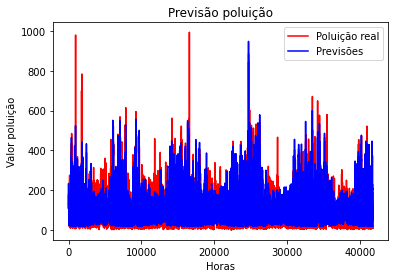

In [ ]:
# Geração do gráfico. Será gerado um gráfico de barras porque temos muitos registros
plt.plot(poluicao, color = 'red', label = 'Poluição real')
plt.plot(previsoes, color = 'blue', label = 'Previsões')
plt.title('Previsão poluição')
plt.xlabel('Horas')
plt.ylabel('Valor poluição')
plt.legend()
plt.show()